# Train_logistic_regression_model_using_mlflow

**Background:**

**Purpose:**

**Methods:**
>1. Introduction
>2. Inits

**Conclusions:**
* Verify that the best models are not just predicting 1's for everyone
* The model that balanced performance, feature count, and class 0 performance had paramters:
   * log10_C between [-0.88889, -0.66667]
   * lower_quantile_removed_CoV between [0.5, 0.9]
* Increaing the # of max_iterations from 1,000 to 10,000 didn't improve the performance
* Final model:
   * log10_C=-1.75
   * lower_quantile_removed_CoV=0.25

# Inits

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import glob

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression

import mlflow

# Load my own custom module
import data_loading
import model_funcs
import constants

import imblearn
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn.metrics as skl_metrics

## Definitions

In [2]:
experiment_base_path = f'{constants.base_dir}/mlruns/'
mlflow.set_tracking_uri(f'file://{experiment_base_path}')


test_param_dict = {'C': 1e-1,
                 'max_iter': 30,
                 'solver': 'saga',
                 'class_weight': None,
                 'lower_quantile_removed_CoV': 0,
                  'use_smote': True}

## Funcs

### Run MLFlow Experiment V5

In [ ]:
def run_mlflow_exp_v9(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict):

    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
                
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X_cv.std(ddof=1, axis=0) / X_cv.mean(axis=0))
        
        # Calculate the qth quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest quantile(s) of genes based on CoV
        X_cv.drop(low_cov_gene_list, axis=1, inplace=True)
        X_test.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []
        
        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]
            
            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)

            curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model on the over-sampled (SMOTE) training data for this k-fold
            log_regr_clf.fit(curr_fold_X_train_smote, curr_fold_y_train_smote)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())
            
            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
            
        
        # Run SMOTE on the full X_cv,y_cv data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)
        
        # Train the model
        log_regr_clf.fit(X_cv_smote, y_cv_smote)
        
        # Calculate test accuracy
        y_test_pred = pd.Series(log_regr_clf.predict(X_test), index=y_test.index)
        test_accuracy = (y_test_pred == y_test).mean()
        
        # Calculate the false positive rate and true positive rate
        train_auc = skl_metrics.roc_auc_score(y_true=y_cv, 
                                             y_score=log_regr_clf.predict_proba(X_cv)[:, 1])
        test_auc = skl_metrics.roc_auc_score(y_true=y_test, 
                                             y_score=log_regr_clf.predict_proba(X_test)[:, 1])
        
        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log CV metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("train_auc", train_auc)
        mlflow.log_metric("test_auc", test_auc)

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

# Eliminating features based on low CoV

In [ ]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')

# Define the parameter grid
param_dict = {'C': np.logspace(-6, 6, 7),
             'max_iter': [100, 300],
             'solver': ['saga'],
             'class_weight': [None, 'balanced'],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5]}

# Loop over the parameter grid
for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)):
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run SMOTE on the X,y data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_smote, y_smote = smote_obj.fit_sample(X, y)

        # Split into CV/test set using target class to stratify
        X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        # Train the model
        log_regr_clf.fit(X_train, y_train)

        # Predict training data
        y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

        # Calculate result metrics like accuracy
        training_accuracy = (y_train_pred == y_train).mean()
        print(f'Train Accuracy: {training_accuracy}')

        # Calculate the proportion of 1s in the predictions and actual y vectors
        ones_in_y_train = y_train.value_counts()[1]
        ones_in_y_train_pred = y_train_pred \
            .value_counts() \
            .reindex(index=[0, 1]) \
            .fillna(0)[1]

        print(f'There were {ones_in_y_train} in the actual y vector and {ones_in_y_train_pred} in the prediction')

        # Log parameters
        mlflow.log_param("C", curr_params_dict['C'])
        mlflow.log_param("max_iter", curr_params_dict['max_iter'])
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        #mlflow.log_metric("support_vector_count", svm_clf.support_vectors_.shape[0])

        # Log sensitivity, specificity
        
        # Log AUC
        print()
        #mlflow.sklearn.log_model(svm_clf, "model")

# Running experiment runs in parallel

In [ ]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-4, 4, 9),
             'max_iter': [100, 1000, 5000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.75]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp)(curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

In [ ]:
def run_mlflow_exp(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V3-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        #print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)
        
        # Run SMOTE on the X,y data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_smote, y_smote = smote_obj.fit_sample(X, y)

        # Split into CV/test set using target class to stratify
        X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        # Train the model
        log_regr_clf.fit(X_train, y_train)

        # Predict training data
        y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

        # Calculate result metrics like accuracy
        training_accuracy = (y_train_pred == y_train).mean()
        #print(f'Train Accuracy: {training_accuracy}')

        # Calculate the proportion of 1s in the predictions and actual y vectors
        ones_in_y_train = y_train.value_counts()[1]
        ones_in_y_train_pred = y_train_pred \
            .value_counts() \
            .reindex(index=[0, 1]) \
            .fillna(0)[1]

        #print(f'There were {ones_in_y_train} in the actual y vector and {ones_in_y_train_pred} in the prediction')

        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        #mlflow.log_metric("support_vector_count", svm_clf.support_vectors_.shape[0])

        # Log sensitivity, specificity
        
        # Log AUC
        #print()
        #mlflow.sklearn.log_model(svm_clf, "model")

# V4 - Adding CV scoring

## Scratch code

In [ ]:
# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Split into CV/test set using target class to stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
kfold_obj = KFold(n_splits=5, shuffle=True)

for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_train, y=y_train):
    
    # Create current fold train data
    curr_fold_X_train = X_train.iloc[curr_train_iloc_list, ]
    curr_fold_y_train = y_train.iloc[curr_train_iloc_list, ]
    
    # Run SMOTE on the X,y data
    smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                             random_state=110, 
                                             k_neighbors=5, 
                                             n_jobs=None)

    curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)
    
    # Train the model on the over-sampled (SMOTE) training data for this k-fold
    
    
    # Get the test data from the non-oversampled data
    
    # Calculate accuracy on non-oversampled data
    

## Running a single run of MLflow

In [ ]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('TEST-l1-Logistic_Regression_Exp')

# Run test
run_mlflow_exp_v5(0, {'C': 0.01,
                      'max_iter': 100,
                      'solver': 'saga',
                      'class_weight': None,
                      'lower_quantile_removed_CoV': 0})

## Running MLFlow

In [ ]:
# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 10).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v5)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

## Plotting # of features vs. training/CV accuracy

In [ ]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('V4-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v4_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v4_df_melt = experiment_results_v4_df.melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter'],
    value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_accuracy_of_0_cases_list'],
    var_name='train_or_cv',
    value_name='accuracy')

sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v4_df_melt,
           hue='train_or_cv', 
           fit_reg=False, size=5, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(10, c='r', alpha=0.3)

* This shows me that the ideal feature count is somewhere around 20-100. 
   * This is because it has a good overall accuracy, while predicting the negative class the best (near 50% accuracy). 
   * Well, this is actually not great since 50% accuracy is as good as a coin-flip. 

# Looking at selected features

In [ ]:
curr_param_index = 0
curr_params_dict = {'C': 2e-2,
                    'max_iter': 1000,
                    'solver': 'saga',
                    'class_weight': None,
                    'lower_quantile_removed_CoV': 0.25}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Remove the lowest quartile of genes based on CoV
# Calculate the CoV
gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))

# Calculate the 0.25 quantile
min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

# Get a list of genes to removed
low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

# Remove the lowest 0.25 quantile of genes based on CoV
X.drop(low_cov_gene_list, axis=1, inplace=True)

# Run SMOTE on the X,y data
smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                         random_state=110, 
                                         k_neighbors=5, 
                                         n_jobs=None)
X_smote, y_smote = smote_obj.fit_sample(X, y)

# Split into CV/test set using target class to stratify
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

# Define the model
log_regr_clf = LogisticRegression(penalty='l1',
                                  C=curr_params_dict['C'],
                                  class_weight=curr_params_dict['class_weight'],
                                  random_state=110,
                                  solver=curr_params_dict['solver'],
                                  max_iter=curr_params_dict['max_iter'],
                                  verbose=0,
                                  n_jobs=None,
                                  l1_ratio=None)

# Run CV
cv_accuracy_list = cross_val_score(estimator=log_regr_clf,
                                   X=X_train,
                                   y=y_train,
                                   groups=None,
                                   scoring='accuracy',
                                   cv=5,
                                   n_jobs=-1)

# Train the model
log_regr_clf.fit(X_train, y_train)

# Predict training data
y_train_pred = pd.Series(log_regr_clf.predict(X_train), index=y_train.index)

# Calculate result metrics like accuracy
training_accuracy = (y_train_pred == y_train).mean()

In [ ]:
cv_accuracy_list

In [ ]:
print(f'There are {np.sum(log_regr_clf.coef_[0] != 0)} non-zero features in the Logistic Regression model')
non_zero_gene_list = X_smote.columns[log_regr_clf.coef_[0] != 0]

In [ ]:
[curr_gene for curr_gene in non_zero_gene_list]

# V5 - Eliminating more quantiles of genes based on CoV

## Running MLFlow

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

## Plotting # of features vs. training/CV accuracy

In [ ]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v9_df_melt = experiment_results_v9_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV',
                   'params.log10_C','params.log10_max_iter'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy',
                      'metrics.cv_test_0_class_accuracy','metrics.test_accuracy','metrics.test_auc'],
          var_name='train_or_cv',
          value_name='accuracy')

In [ ]:
sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v9_df_melt,
           hue='train_or_cv',
           fit_reg=False, size=6, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(200, c='r', alpha=0.3)

In [ ]:
experiment_results_v9_df_melt\
    .loc[(experiment_results_v9_df_melt['metrics.count_non_zero_features'] > 150)
        & (experiment_results_v9_df_melt['metrics.count_non_zero_features'] < 300)]

# Investigating the best class 0 prediction cases

In [ ]:
experiment_results_v5_df.loc[np.abs(experiment_results_v5_df['params.log10_C'] + 0.88888889) < 0.01]

So the best performing model had paramters:
* log10_C between [-0.88889, -0.66667]
* lower_quantile_removed_CoV between [0.5, 0.9]

In [ ]:
experiment_results_v5_df.dtypes

In [ ]:
experiment_results_v5_df\
    .loc[(experiment_results_v5_df['metrics.cv_test_accuracy_of_0_cases_list'] > 0.5)]\
    .iloc[:, 6:]

# Getting features of model

In [ ]:
def run_mlflow_exp_v6(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')
    #mlflow.set_experiment('V4-l1-Logistic_Regression_Exp')
    
    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        In this run, I added a parameter that controls what lower quantile of the data is removed based on CoV.
        """)
        
        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)
        
        #print(curr_param_index, curr_params_dict)
        # Define the description and tags
        #mlflow_funcs.define_description_and_tags(mlflow)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()
        
        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))
        
        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]
        
        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()
        
        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)

        # Split into CV/test set using target class to stratify
        X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        
        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []
        
        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]
            
            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)

            curr_fold_X_train_smote, curr_fold_y_train_smote = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model on the over-sampled (SMOTE) training data for this k-fold
            log_regr_clf.fit(curr_fold_X_train_smote, curr_fold_y_train_smote)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())
            
            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)
            
        
        # Run SMOTE on the full X_cv,y_cv data
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)
        
        # Train the model
        log_regr_clf.fit(X_cv_smote, y_cv_smote)
        
        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        
        # Log accuracy metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_accuracy_of_0_cases_list", np.mean(cv_test_accuracy_of_0_cases_list))

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))
        
        # Log sensitivity, specificity
        
        # Log AUC
        
        #mlflow.sklearn.log_model(svm_clf, "model")

In [ ]:
# Define the model
log_regr_clf = LogisticRegression(penalty='l1',
                                  C=1e-1,
                                  class_weight=None,
                                  random_state=110,
                                  solver='saga',
                                  max_iter=50,
                                  verbose=0,
                                  n_jobs=None,
                                  l1_ratio=None)

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Run SMOTE on the full X_cv,y_cv data
smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                         random_state=110, 
                                         k_neighbors=5, 
                                         n_jobs=None)
X_cv_smote, y_cv_smote = smote_obj.fit_sample(X_cv, y_cv)

# Train the model
log_regr_clf.fit(X_cv_smote, y_cv_smote)

In [ ]:
# Getting the top genes
coef_list = pd.Series(log_regr_clf.coef_[0], index=X_cv.columns.tolist())

for i in np.abs(coef_list).sort_values(ascending=False).head(100).index:
    print(i)

In [ ]:
[print(i) for i in coef_list.sort_values(ascending=False).head(50).index]

In [ ]:
coef_list.sort_values(ascending=False).tail(50)

# Exp 1 - Increasing maximum iters to see if performance improves

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-Exp_1-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': [1e-2, 1e-1, 1],
             'max_iter': [1000, 10000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

In [ ]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-Exp_1-L1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_exp_1_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v9_exp_1_df_melt = experiment_results_v9_exp_1_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV',
                   'params.log10_C','params.log10_max_iter'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy',
                      'metrics.cv_test_0_class_accuracy','metrics.test_accuracy','metrics.test_auc'],
          var_name='train_or_cv',
          value_name='accuracy')

**Increaing the # of max_iterations from 1,000 to 10,000 didn't improve the performance**

# Exp 2 - Investigating the train and test AUC

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V9-Exp_2-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100, 1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v9)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

In [ ]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V9-Exp_2-L1-Logistic_Regression_Exp').experiment_id

experiment_results_v9_exp_2_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

experiment_results_v9_exp_2_df.loc[:, ['params.log10_C','metrics.count_non_zero_features','metrics.train_auc','metrics.test_auc']]

In [ ]:
experiment_results_v9_exp_2_df.loc[:, ['params.log10_C','metrics.count_non_zero_features',
                                       'metrics.train_auc','metrics.cv_test_accuracy','metrics.test_auc']]\
    .iloc[31:80, :]\
    .sort_values('metrics.count_non_zero_features')

In [ ]:
experiment_results_v9_exp_2_df\
    .iloc[[40,52], 6:]

So it seems like using only ~30 predictors is not quite enough to generate a good model; The test accuracy and AUC is very close to 50%. This can be improved by 

# Exp 3 - Experimenting on multiple CV/Test data

## Quick test

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V10-TEST-L1-Logistic_Regression_Exp')

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

model_funcs.run_mlflow_exp_V10(X_cv, X_test, y_cv, y_test, test_param_dict, experiment_base_path)

## Running full MLFlow Exp

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC1-V10-Exp_3-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 9).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'use_smote': [True]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc1_data()

for i in range(15):
    # Split into CV/test set using target class to stratify
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)

    #model_funcs.run_mlflow_exp_V10(X_cv, X_test, y_cv, y_test, test_param_dict, experiment_base_path)

    # Run mlflow runs in parallel
    results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
        (joblib.delayed(model_funcs.run_mlflow_exp_V10)(X_cv, X_test, y_cv, y_test, curr_params_dict, experiment_base_path)\
             for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

## Creating a dataframe with experiment results

In [4]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC1-V10-Exp_3-L1-Logistic_Regression_Exp').experiment_id

experiment_results_sc1_v10_exp3_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_sc1_v10_exp3_df_melt = experiment_results_sc1_v10_exp3_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

experiment_results_sc1_v10_exp3_df_melt['metrics.log10_count_non_zero_features'] = np.log10(experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] + 1)

## Plotting the results

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


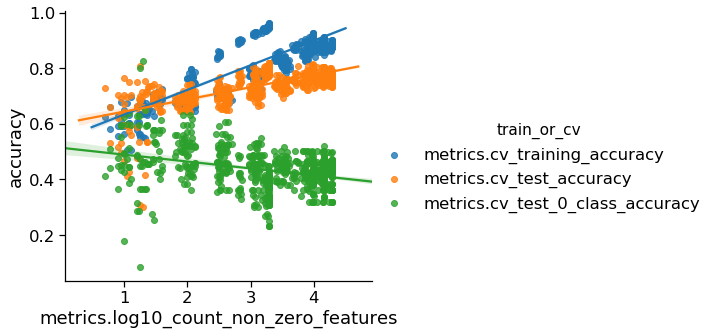

In [5]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]

sns.lmplot(x='metrics.log10_count_non_zero_features',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           fit_reg=True, size=5, aspect=1.25)

ax = plt.gca()
#ax.set_xscale('log')
#ax.axvline(3, c='r', alpha=0.3)

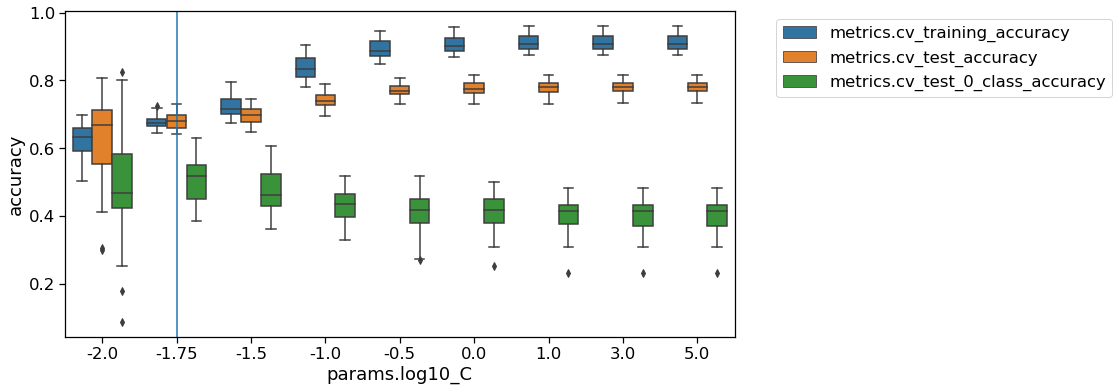

In [8]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]

plt.figure(figsize=(12,6))
ax=plt.gca()

sns.boxplot(x='params.log10_C',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           order=['-2.0', '-1.75', '-1.5', '-1.0', '-0.5', '0.0', '1.0', '3.0', '5.0'],
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
#ax.axhline(0.5, c='g')
ax.axvline(1)

In order to balance the performance of class 0 cases with overall test accuracy, a model with log10_C=-1.75 was chosen

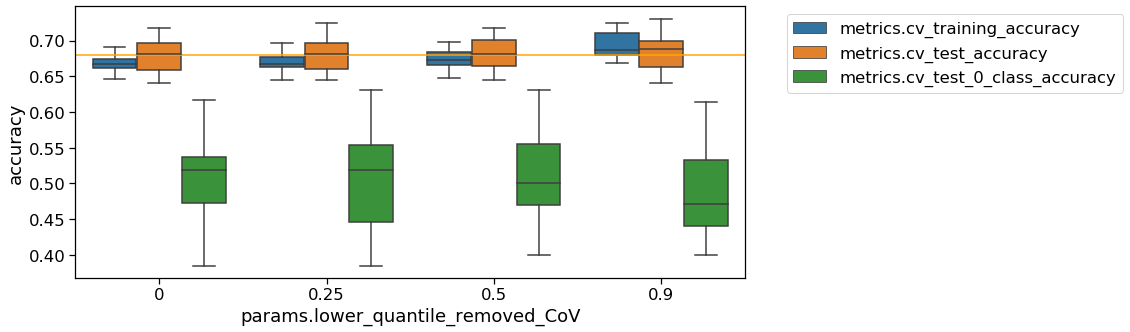

In [19]:
plot_df = experiment_results_sc1_v10_exp3_df_melt\
    .loc[experiment_results_sc1_v10_exp3_df_melt['metrics.count_non_zero_features'] > 1]\
    .loc[experiment_results_sc1_v10_exp3_df_melt['params.log10_C'] == '-1.75']

plt.figure(figsize=(12,5))
ax=plt.gca()

sns.boxplot(x='params.lower_quantile_removed_CoV',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
ax.axhline(0.68, c='orange')
#ax.axvline(1)

After removing ~0.5 quantiles of lower CoV genes, the variance of class 0 accuracy increases. Therefore, I will remove only 0.25 quantiles of lower CoV genes. 

Final model:
* log10_C=-1.75
* lower_quantile_removed_CoV=0.25

In [10]:
experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]\
    .filter(regex='metrics.*')\
    .describe()

,metrics.train_auc,metrics.test_accuracy,metrics.test_specificity,metrics.cv_test_accuracy,metrics.count_non_zero_features,metrics.cv_test_auc,metrics.test_auc,metrics.cv_test_0_class_accuracy,metrics.cv_training_accuracy,metrics.test_sensitivity,metrics.train_accuracy
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.739493,0.673684,0.460000,0.680579,94.066667,0.591588,0.599798,0.510291,0.670139,0.706061,0.669615
std,0.017243,0.063142,0.118322,0.025117,13.863965,0.024298,0.077275,0.069335,0.014074,0.070789,0.018348
min,0.718107,0.578947,0.200000,0.644372,69.000000,0.544559,0.456061,0.384689,0.645031,0.590909,0.640385
25%,0.725244,0.618421,0.400000,0.659508,82.500000,0.575047,0.560606,0.446172,0.662732,0.659091,0.656731
50%,0.740089,0.684211,0.500000,0.680929,97.000000,0.589118,0.593939,0.519048,0.666982,0.696970,0.669231
75%,0.748018,0.723684,0.500000,0.696148,104.500000,0.607786,0.647727,0.554206,0.676895,0.757576,0.679808
max,0.776834,0.763158,0.700000,0.724372,115.000000,0.638368,0.712121,0.630556,0.696137,0.818182,0.711538


## Loading the feature lists for these models

In [11]:
# Get the full run_id list for this experiment
run_id_list = experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]\
    ['run_id']

In [12]:
full_feature_list = []

for curr_run_id in run_id_list:
    # Get the current run's artifact uri
    curr_run = mlflow.get_run(run_id=curr_run_id)
    curr_artifact_uri = curr_run.to_dictionary()['info']['artifact_uri']

    # Get the feature list filepath
    feature_list_filepath = glob.glob(f'{curr_artifact_uri[7:]}/*')[0]
    
    # Open the feature list file
    with open(feature_list_filepath, 'r') as f:
        # Get the first feature
        curr_feature = f.readline()

        # While the current feature name is not empty
        while curr_feature != '':
            # Add the feature to the full feature list
            full_feature_list.append(f.readline().strip())
            
            # Get the next feature
            curr_feature = f.readline()

(array([84., 29., 27., 26., 15., 13., 15.,  5.,  6.,  3.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

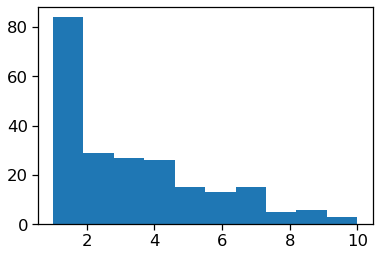

In [13]:
full_sc1_feature_ser = pd.Series(full_feature_list)
full_sc1_feature_counts_ser = full_sc1_feature_ser.value_counts()

plt.hist(full_sc1_feature_counts_ser)

This histogram shows that some features were found in nearly every model. These are the more likely candidates for predictive features

* Looking at the PPI network of genes with >5 occurrences yielded a poorly connected network
* Looking at the PPI of all genes yielded an extremely well connected network

In [16]:
full_sc1_feature_counts_ser.loc[full_sc1_feature_counts_ser >= 5]

PLAT            10
SYTL4           10
TIMP1           10
FAM110C          9
CRNDE            9
FLJ16779         9
SFRP2            9
BMP2             9
GOLGA8A          9
SNHG19           8
IGFBP2           8
PDPN             8
LINC01088        8
MTHFD2           8
DLL3             7
LPL              7
NMB              7
NRN1             7
ARHGEF26.AS1     7
EMP3             7
TPPP3            7
ENC1             7
SELL             7
CASTOR1          7
                 7
SRPX             7
IL13RA2          7
CXCL14           7
EMX2             7
ADM              6
RCAN2            6
PRKX             6
FERMT1           6
SLC14A1          6
ASS1             6
LHFPL3           6
TMEM100          6
SLC39A12         6
SERPINE1         6
CHI3L1           6
RBP1             6
BCHE             6
SLC24A3          5
NEFH             5
SNX10            5
TMEM158          5
AKR1C3           5
PCP4             5
SHD              5
PKIB             5
GBP1             5
KLRC3            5
C2orf27A    

## Output the final feature list

In [ ]:
with open('./../../data/intermediate/GE_feature_list.txt', 'w') as f:
    for curr_feature in np.sort(np.unique(full_feature_list)):
        if len(curr_feature) > 0:
            f.write(f'{curr_feature}\n')

## Getting the final metrics

In [ ]:
experiment_results_sc1_v10_exp3_df_final = experiment_results_sc1_v10_exp3_df\
    .loc[(experiment_results_sc1_v10_exp3_df['params.log10_C'] == '-1.75')
        & (experiment_results_sc1_v10_exp3_df['params.lower_quantile_removed_CoV'] == '0.25')]

In [ ]:
experiment_results_sc1_v10_exp3_df_final

In [ ]:
experiment_results_sc1_v10_exp3_df_final\
    .filter(regex='metrics.*')\
    [['metrics.test_accuracy','metrics.train_auc','metrics.test_auc']]\
    .describe()